In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
from lsst.daf.butler import Butler
import lsst.geom as geom
from astropy.io import ascii as astascii
import anacal
import scipy.integrate as integrate
import scipy.stats as stats
import astropy.table as astTable
import fitsio
import pandas as pd

import lsst.geom as geom

arcsec = 1/60**2
rng = np.random.default_rng()
omega_m = .31
omega_de= .69
omega_r = 0
H0 = 70 # km/s/Mpc
c = 3e5 # km/s

Hz = lambda z : c/(H0  * np.sqrt((omega_de + omega_m * (1+z)**3 + omega_r * (1+z)**4)))
chi_dl = lambda z, z0=0 : integrate.quad(Hz, z0, z)[0]
Da = lambda z : chi_dl(z)/(1+z)
beta_r = lambda zl, zs : integrate.quad(Hz, zl, zs)[0]/integrate.quad(Hz, 0, zs)[0]

In [2]:
obs_repo = '/lustre/work/xiangchong.li/work/hsc_s23b_sim'
obs_collection = 'version1/image'

obs_butler = Butler(obs_repo, collections=obs_collection)
obs_registry = obs_butler.registry
skymap = obs_butler.get('skyMap', skymap="hsc")
clusters = astTable.Table.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/s23b-camira/camira_s23b_wide_v2.csv")
sel = (clusters["logMs"] > 12.5) & (clusters["z_bcg"] > 0) & (clusters["z_bcg"] < 0.2) & (clusters["N_mem"] > 60)

In [105]:
cc = clusters[sel][9]
cc

ra,dec,z_cl,N_mem,logMs,z_bcg,ID
float64,float64,float64,float64,float64,float64,int64
181.146398,3.95643,0.168,72.474,12.897,0.16266,16916


In [106]:
# Position of the BCG for A360
ra_bcg = cc["ra"]
dec_bcg = cc["dec"]

# Looking for all patches in delta deg region around it
delta = 0.5
center = geom.SpherePoint(ra_bcg, dec_bcg, geom.degrees)
ra_min, ra_max = ra_bcg - delta, ra_bcg + delta
dec_min, dec_max = dec_bcg - delta, dec_bcg + delta

ra_range = (ra_min, ra_max)
dec_range = (dec_min, dec_max)
radec = [geom.SpherePoint(ra_range[0], dec_range[0], geom.degrees),
         geom.SpherePoint(ra_range[0], dec_range[1], geom.degrees),
         geom.SpherePoint(ra_range[1], dec_range[0], geom.degrees),
         geom.SpherePoint(ra_range[1], dec_range[1], geom.degrees)]

tracts_and_patches = skymap.findTractPatchList(radec)

tp_dict = {}
for tract_num in np.arange(len(tracts_and_patches)):
    tract_info = tracts_and_patches[tract_num][0]
    tract_idx = tract_info.getId()
    # All the patches around the cluster
    patches = []
    for i,patch in enumerate(tracts_and_patches[tract_num][1]):
        patch_info = tracts_and_patches[tract_num][1][i]
        patch_idx = patch_info.sequential_index
        patches.append(patch_idx)
    tp_dict.update({tract_idx:patches})

In [107]:
bdir = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal2"
data = []
for tid in tp_dict.keys():
    patches = tp_dict[tid]
    for pid in patches:
        catdir = f"{bdir}/{tid}/{pid}"
        fname = os.path.join(catdir, "match.fits")
        if os.path.isfile(fname):
            dd = astTable.Table.read(fname)
            data.append(dd)
data = astTable.vstack(data)

In [108]:
def anacal_get_tang_cross(shear, sky_dist, bins, R1, R2):
    ci_level = 0.68
    nb = len(bins) - 1
    tang_avg = np.zeros(nb)
    cross_avg = np.zeros_like(tang_avg)

    tang_err = np.zeros(nb)
    cross_err = np.zeros_like(tang_err)

    for i in range(nb):
        # bin_rs.append(bins[i])
        ndx_filt = (sky_dist > bins[i]) * (sky_dist <= bins[i+1])
        if np.sum(ndx_filt) < 10:
            continue
            
        sample = shear[ndx_filt]
        sample_t = sample.real
        sample_x = sample.imag

        sample_r1 = np.mean(R1[ndx_filt])
        sample_r2 = np.mean(R2[ndx_filt])

        R_correction = (.5 * (sample_r1 + sample_r2)) 
        
        ta = np.mean(sample_t) / R_correction
        xa = np.mean(sample_x) / R_correction
        
        te = np.std(sample_t) / np.sqrt(np.sum(ndx_filt)) / R_correction
        xe = np.std(sample_x) / np.sqrt(np.sum(ndx_filt)) / R_correction
        
        tang_avg[i] = ta
        cross_avg[i] = xa
        tang_err[i] = te 
        cross_err[i] = xe 

    return tang_avg, cross_avg, tang_err, cross_err

In [109]:
cluster_coords = (ra_bcg, dec_bcg)
source_phi = np.arctan2(
    data['dec'] - cluster_coords[1], 
    (data['ra'] - cluster_coords[0]) * np.cos(np.deg2rad(cluster_coords[1]))
)
ang_dist = np.sqrt(((data['ra'] - cluster_coords[0]) * np.cos(np.deg2rad(cluster_coords[1])))**2 + (data['dec'] - cluster_coords[1])**2)
sky_distance = Da(cc["z_cl"]) * ang_dist * (np.pi/180)

e1 = data["e1"] * data["wsel"]
e2 = data["e2"] * data["wsel"]
R1 = data["de1_dg1"] * data["wsel"] + data["dwsel_dg1"] * data["e1"]
R2 = data["de2_dg2"] * data["wsel"] + data["dwsel_dg2"] * data["e2"]

trial_shear = e1 + 1j * e2
cl_shear = trial_shear * -1 * np.exp(-2j*source_phi)

bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])
bin_mids = 1/2 * (bins_mpc[1:] + bins_mpc[:-1])

In [110]:
shear_cl = anacal_get_tang_cross(cl_shear, sky_distance, bins_mpc, R1, R2)

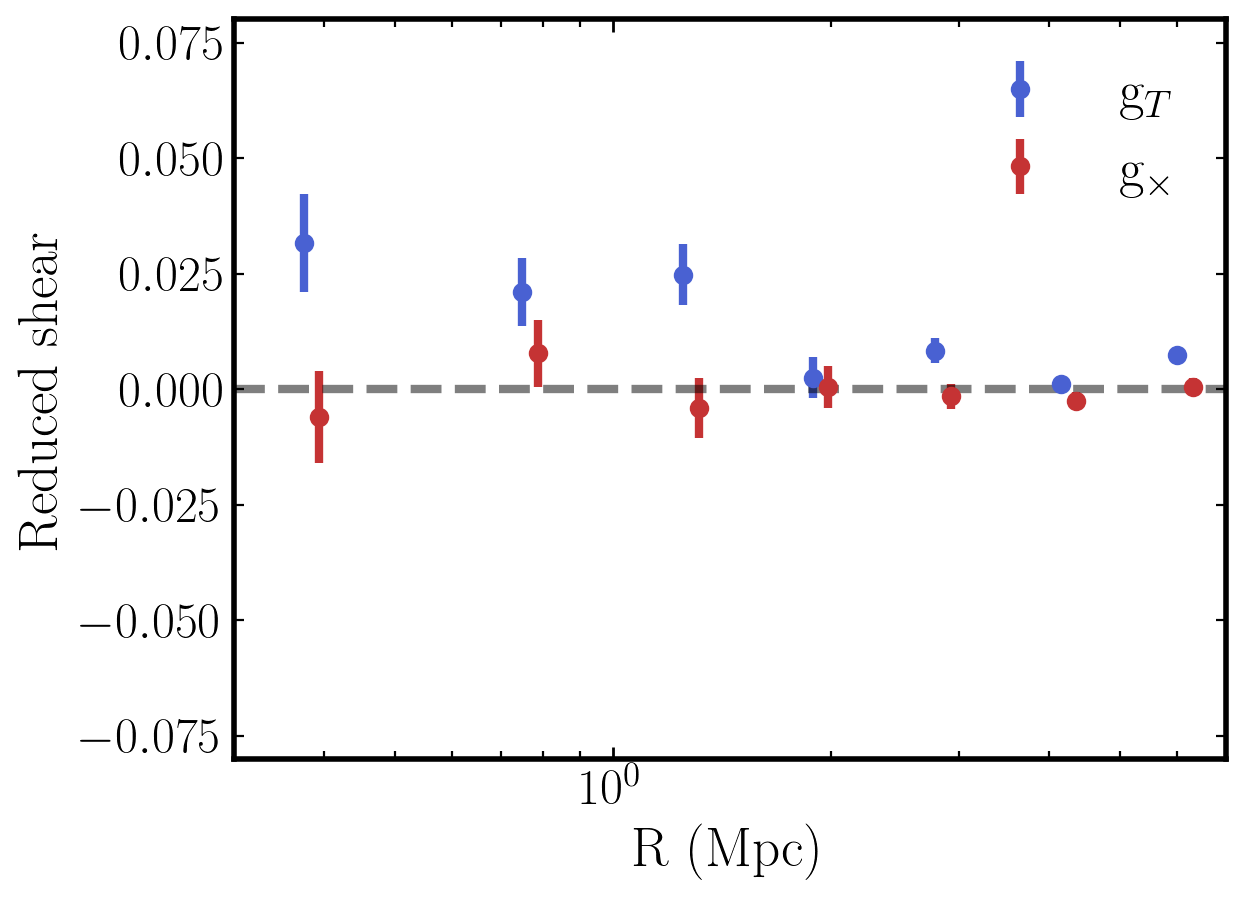

In [111]:
cmap = cm.coolwarm

plt.errorbar(bin_mids, shear_cl[0], shear_cl[2], marker="o", linestyle="", label=r'g$_T$', color=cmap(.05))
plt.errorbar(1.05*bin_mids, shear_cl[1], shear_cl[3], marker="o", linestyle="", label=r'g$_\times$', color=cmap(.95))
plt.semilogx()
plt.axhline(0, ls='--', color='k', alpha=.5)

plt.ylim([-0.08,0.08])
plt.xlim([0.3,7])
plt.ylabel("Reduced shear")
plt.xlabel("R (Mpc)")
plt.legend(frameon=False, loc='upper right')